# **STOCKS SELECTION**

- Purpose: Pick out a pair of stocks among a group of stocks.

#### **I. Imports and Load data***

In [18]:
# General
import numpy as np
import pandas as pd
import os
import sys
import pathlib
import datetime

# Statistics
from scipy.stats import gmean

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set()

# utils
sys.path.append(os.path.abspath('..'))
from src.utils.get_data import get_stock, get_risk_free
from src.stocksmanage.asset_allocation import gen_prob_set, Weight_2Stocks_Portfolio

In [19]:
# Configs
NUM_DAYS_YEAR = 252
potential_stocks = ['CII', 'FPT', 'HPG', 'VCB']
START_DATE = '2007-01-01'
END_DATE = '2025-01-09'
#END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

In [20]:
# Vietnam 10Y bond data - 01/01/2015 to 28/09/2025 - link: https://vn.investing.com/rates-bonds/vietnam-10-year-bond-yield-historical-data
bond_data = pd.read_csv(os.path.join(pathlib.Path.cwd().parent, 'data', 'Dữ liệu Lịch sử Suất Thu lợi Trái phiếu 10 Năm Việt Nam.csv'))
bond_data.shape

(2824, 6)

In [21]:
bond_data.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,% Thay đổi
0,26/09/2025,3.759,3.759,3.759,3.759,0.24%
1,25/09/2025,3.750,3.750,3.750,3.750,1.16%
2,24/09/2025,3.707,3.707,3.707,3.707,0.00%
3,23/09/2025,3.707,3.707,3.707,3.707,0.00%
4,22/09/2025,3.707,3.703,3.707,3.703,0.08%


In [22]:
bond_data['return'] = bond_data['% Thay đổi'].str.replace('%', '').astype(float) / 100
bond_data.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,% Thay đổi,return
0,26/09/2025,3.759,3.759,3.759,3.759,0.24%,0.0024
1,25/09/2025,3.750,3.750,3.750,3.750,1.16%,0.0116
2,24/09/2025,3.707,3.707,3.707,3.707,0.00%,0.0000
3,23/09/2025,3.707,3.707,3.707,3.707,0.00%,0.0000
4,22/09/2025,3.707,3.703,3.707,3.703,0.08%,0.0008


In [23]:
bond_data[bond_data['return'] < 0]

,Ngày,Lần cuối,Mở,Cao,Thấp,% Thay đổi,return
7,17/09/2025,3.689,3.690,3.690,3.689,-0.03%,-0.0003
9,15/09/2025,3.690,3.695,3.695,3.690,-0.14%,-0.0014
15,05/09/2025,3.664,3.693,3.693,3.664,-0.79%,-0.0079
21,28/08/2025,3.685,3.690,3.690,3.685,-0.14%,-0.0014
27,20/08/2025,3.561,3.561,3.561,3.561,-0.06%,-0.0006
...,...,...,...,...,...,...,...
2812,16/01/2015,6.975,6.975,6.975,6.975,-1.19%,-0.0119
2814,14/01/2015,7.051,7.051,7.051,7.051,-1.41%,-0.0141
2816,12/01/2015,7.148,7.148,7.148,7.148,-0.10%,-0.0010
2817,09/01/2015,7.155,7.155,7.155,7.155,-0.01%,-0.0001


Half of the samples were negative, even the 10 year bond is some what suffer alot from downturn.

In [24]:
geo_mean_risk_free = np.prod(1 + bond_data['return'])
rf = geo_mean_risk_free**(252/bond_data.shape[0]) - 1
rf

np.float64(-0.055871521148385894)

In [25]:
rf = max(0, rf)

So mean risk free rate in the 5 years is negative, assume as 0.

In [26]:
# Load data
data = {}

for stock in potential_stocks:
    data[stock] = get_stock(stock, START_DATE, END_DATE)

for stock_name, stock in data.items():
    print(f'{stock_name}: {stock.shape}')

CII: (4493, 8)
FPT: (4493, 8)
HPG: (4277, 8)
VCB: (3881, 8)


In [27]:
# Get probability set
num_combinations = 1000
num_dimensions = 2
probability_set = gen_prob_set(num_combinations, num_dimensions)


-------------------------------------------------------------------------------------
[CII] & [FPT] - Corr: 0.40 - Optimized Sharpe ratio: 0.48 


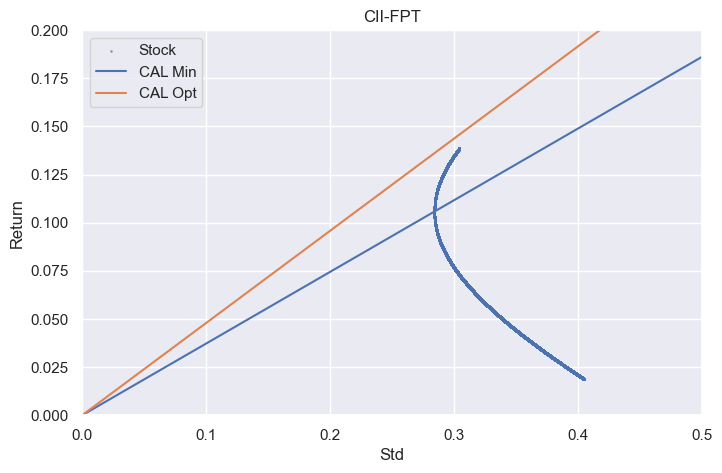


-------------------------------------------------------------------------------------
[CII] & [HPG] - Corr: -0.04 - Optimized Sharpe ratio: 0.40 


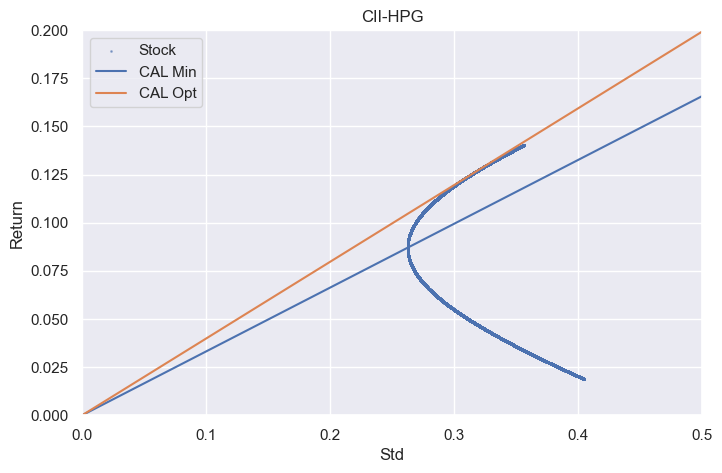


-------------------------------------------------------------------------------------
[CII] & [VCB] - Corr: -0.01 - Optimized Sharpe ratio: 0.41 


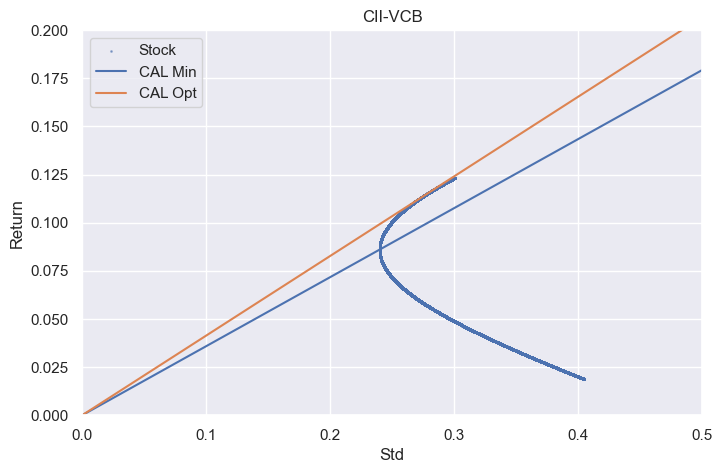


-------------------------------------------------------------------------------------
[FPT] & [HPG] - Corr: -0.03 - Optimized Sharpe ratio: 0.61 


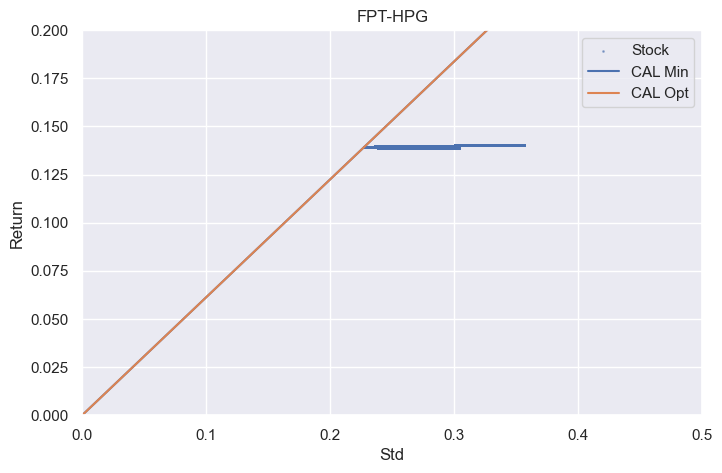


-------------------------------------------------------------------------------------
[FPT] & [VCB] - Corr: 0.01 - Optimized Sharpe ratio: 0.61 


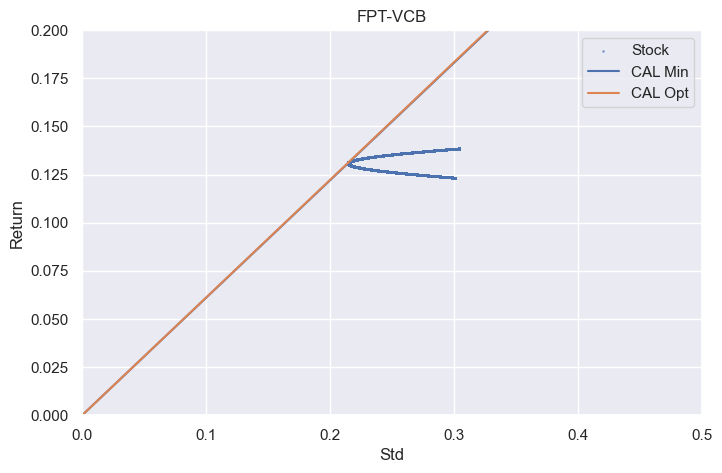


-------------------------------------------------------------------------------------
[HPG] & [VCB] - Corr: 0.01 - Optimized Sharpe ratio: 0.57 


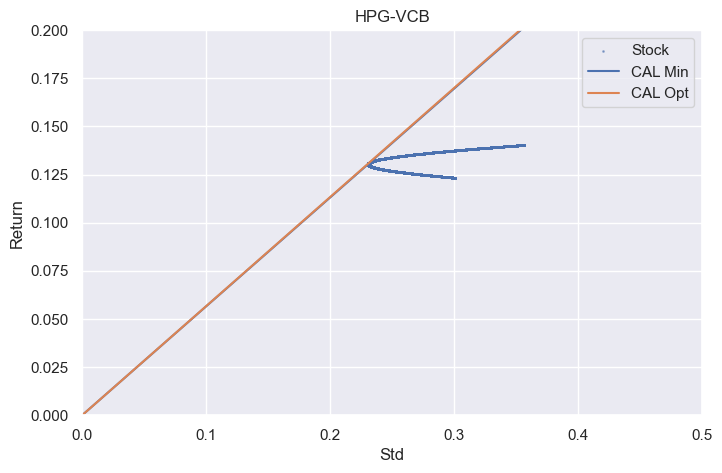

In [28]:
# Print all pairs of stocks
probability_set_pair = gen_prob_set(100000, 2)
checked = []
x = np.linspace(0, 0.7, 100)

for stock_name1, stock1 in data.items():
    checked.append(stock_name1)
    for stock_name2, stock2 in data.items():
        if stock_name2 in checked:
            continue
        ws = Weight_2Stocks_Portfolio(stock1, stock2, probability_set_pair, rf)
        report = ws.get_report()
        corelation = ws.corel
        y_min = ws.min_CAL(x)
        y_opt = ws.opt_CAL(x)
        opt_sharpe = ws.sharpe_ratio_opt

        print()
        print('-------------------------------------------------------------------------------------')
        print(f'[{stock_name1}] & [{stock_name2}] - Corr: {corelation:.2f} - Optimized Sharpe ratio: {opt_sharpe:.2f} ')
        plt.figure(figsize=(8, 5))
        plt.scatter(report['Std'], report['Return'], alpha=0.5, s=1, label="Stock")
        plt.plot(x, y_min, label="CAL Min")
        plt.plot(x, y_opt, label="CAL Opt")
        plt.xlabel('Std')
        plt.ylabel('Return')
        plt.title(f'{stock_name1}-{stock_name2}')
        plt.xlim((0, 0.5))
        plt.ylim((0, 0.2))
        plt.legend()
        plt.show()

- Active trading does not usally go with portfolio building but this help choosing combo that could mitigate the risk of trading on only one stocks (if one stock performs too poorly)

In [29]:
# Check on recent data
recent_data = {}

for stock in potential_stocks:
    recent_data[stock] = get_stock(stock, START_DATE, END_DATE)[3000:]

for stock_name, stock in recent_data.items():
    print(f'{stock_name}: {stock.shape}')

CII: (1493, 8)
FPT: (1493, 8)
HPG: (1277, 8)
VCB: (881, 8)



-------------------------------------------------------------------------------------
[CII] & [FPT] - Corr: 0.36 - Optimized Sharpe ratio: 1.60 


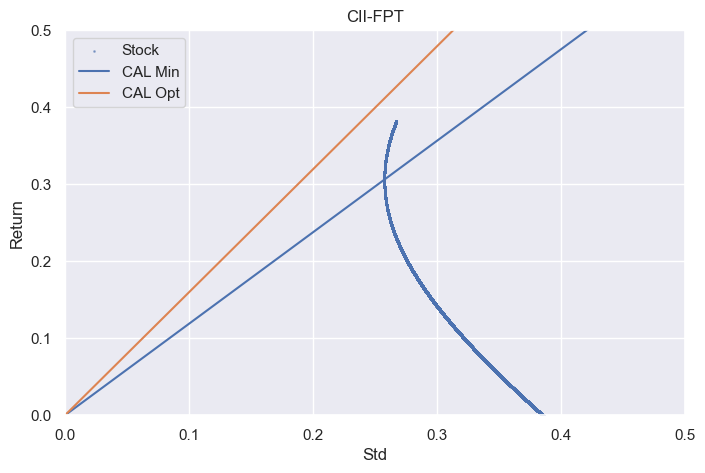


-------------------------------------------------------------------------------------
[CII] & [HPG] - Corr: -0.03 - Optimized Sharpe ratio: 0.58 


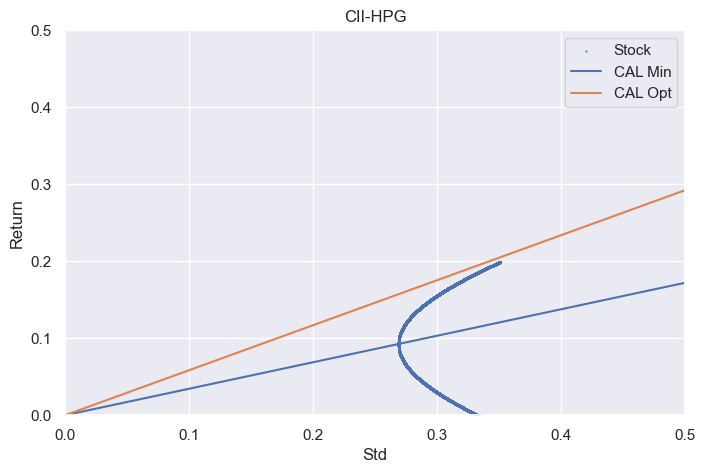


-------------------------------------------------------------------------------------
[CII] & [VCB] - Corr: -0.02 - Optimized Sharpe ratio: 0.30 


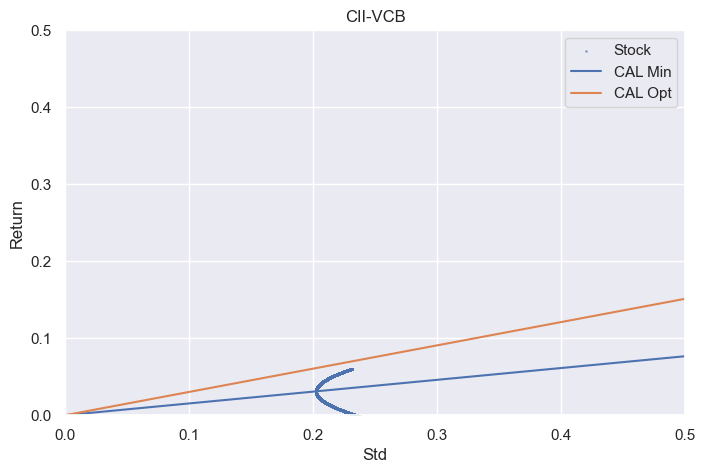


-------------------------------------------------------------------------------------
[FPT] & [HPG] - Corr: -0.03 - Optimized Sharpe ratio: 1.55 


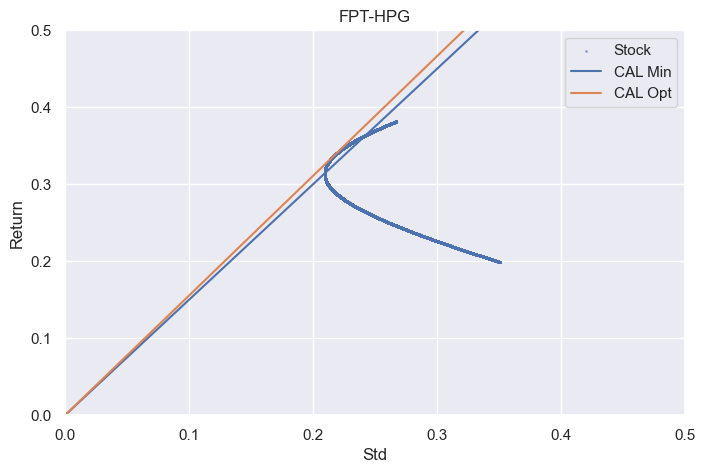


-------------------------------------------------------------------------------------
[FPT] & [VCB] - Corr: 0.04 - Optimized Sharpe ratio: 1.44 


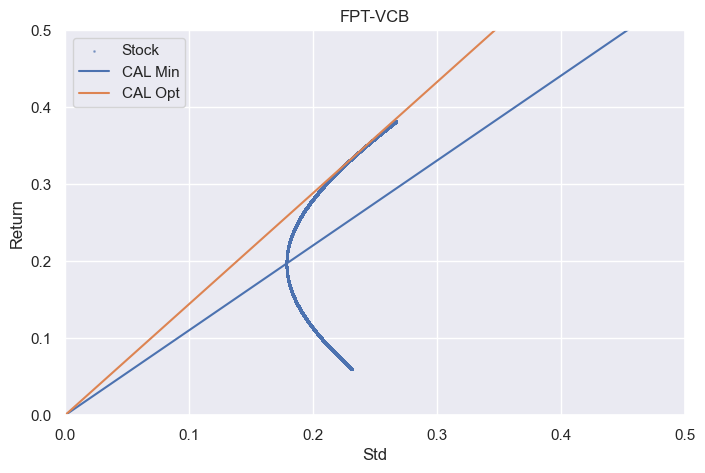


-------------------------------------------------------------------------------------
[HPG] & [VCB] - Corr: 0.00 - Optimized Sharpe ratio: 0.62 


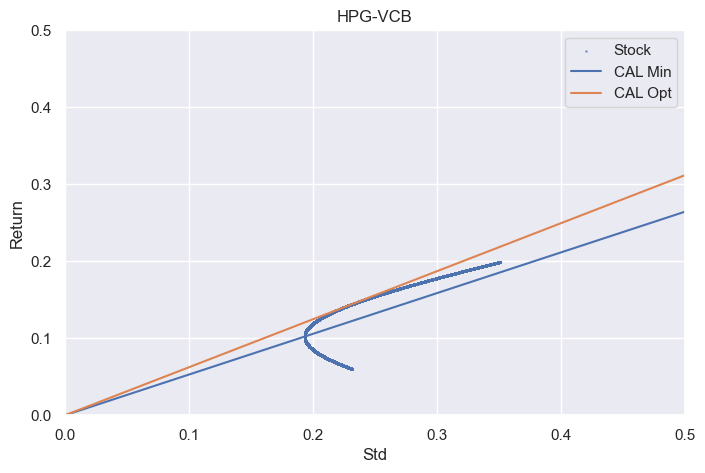

In [30]:
# Print all pairs of stocks
probability_set_pair = gen_prob_set(100000, 2)
checked = []
x = np.linspace(0, 0.7, 100)

for stock_name1, stock1 in recent_data.items():
    checked.append(stock_name1)
    for stock_name2, stock2 in recent_data.items():
        if stock_name2 in checked:
            continue
        ws = Weight_2Stocks_Portfolio(stock1, stock2, probability_set_pair, rf)
        report = ws.get_report()
        corelation = ws.corel
        y_min = ws.min_CAL(x)
        y_opt = ws.opt_CAL(x)
        opt_sharpe = ws.sharpe_ratio_opt

        print()
        print('-------------------------------------------------------------------------------------')
        print(f'[{stock_name1}] & [{stock_name2}] - Corr: {corelation:.2f} - Optimized Sharpe ratio: {opt_sharpe:.2f} ')
        plt.figure(figsize=(8, 5))
        plt.scatter(report['Std'], report['Return'], alpha=0.5, s=1, label="Stock")
        plt.plot(x, y_min, label="CAL Min")
        plt.plot(x, y_opt, label="CAL Opt")
        plt.xlabel('Std')
        plt.ylabel('Return')
        plt.title(f'{stock_name1}-{stock_name2}')
        plt.xlim((0, 0.5))
        plt.ylim((0, 0.5))
        plt.legend()
        plt.show()

For recent data (around the nearest 10 years):  
The three highest Sharpe ratio scores are from: 
- CII-FPT: opt return around 0.55, std around 0.34, sharpe: 1.60
- FPT-HPG: opt return around 0.34, std around 0.22, sharpe: 1.55
- FPT-VCB: opt return around 0.33, std around 0.23, sharpe: 1.44  
=> In this project, I would choose CII-FPT combination (seemingly highest return rate with moderate volatility and good enough Sharpe ratio).

In [33]:
# Weights on CII - FPT portfolio
ws = Weight_2Stocks_Portfolio(recent_data['CII'], recent_data['FPT'], probability_set_pair, rf)
W_CII = ws.w1_opt
W_FPT = ws.w2_opt
print("CII: ", W_CII)
print("FPT: ", W_FPT)
print(f'Port folio expected return: {ws.Ep_opt:.2f}')
print(f'Port folio std: {ws.stdp_opt:.4f}')

CII:  -0.37965478817474524
FPT:  1.3796547881747452
Port folio expected return: 0.55
Port folio std: 0.3462
